Čia bus neuroninis tinklas

In [1]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from optuna.integration import TFKerasPruningCallback

# --- data prep (example) ---
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

input_dim   = X_train.shape[1]
num_classes = len(np.unique(y_train))

# --- simplified Optuna objective ---
def objective(trial):
    # 1) hyperparameters to tune
    units     = trial.suggest_int("units", 32, 256, step=32) # 32 ,64, 96, 128, 160, 192, 224, 256
    # activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    # learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    # optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    # dropout   = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    batch_sz  = trial.suggest_categorical("batch_size", [16, 32, 64])

    # 2) build model
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ])

    # 3) compile with a fixed optimizer
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # 4) fit with pruning callback
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        TFKerasPruningCallback(trial, "val_loss"),
        TensorBoard(log_dir="logs/fit/" + str(trial.number), histogram_freq=1, write_graph=True, write_images=True)
    ]
    
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=batch_sz,
        callbacks=callbacks,
        verbose=0
    )

    # 5) evaluate
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return val_acc

# --- run the study ---
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=25)

print("Best params:", study.best_trial.params)
print("Best val accuracy: {:.4f}".format(study.best_value))



c:\Users\guiku\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-25 08:31:04,540] A new study created in memory with name: no-name-0a554856-ce39-4d95-a392-602d9a523608
[I 2025-04-25 08:31:08,035] Trial 0 finished with value: 0.8999999761581421 and parameters: {'units': 192, 'batch_size': 32}. Best is trial 0 with value: 0.8999999761581421.
[I 2025-04-25 08:31:10,665] Trial 1 finished with value: 0.6666666865348816 and parameters: {'units': 64, 'batch_size': 32}. Best is trial 0 with value: 0.8999999761581421.
[I 2025-04-25 08:31:13,456] Trial 2 finished with value: 0.9666666388511658 and parameters: {'units': 192, 'batch_size': 16}. Best is trial 2 with value: 0.9666666388511658.
[I 2025-04-25 08:31:16,132] Trial 3 finished with value: 0.9666666388511658 and paramet

Best params: {'units': 160, 'batch_size': 16}
Best val accuracy: 1.0000


In [3]:
# predict on new data
X_test = np.array([[5.0, 3.6, 1.4, 0.2], [6.0, 3.0, 4.8, 1.8]])
# Retrieve the best model from the study
best_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(study.best_trial.params["units"], activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])

# Compile the model
best_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model on the training data
best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=study.best_trial.params["batch_size"],
    verbose=0
)

# Use the trained model for prediction
y_pred = best_model.predict(X_test)
print("Predictions:", y_pred.argmax(axis=1))  # class indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions: [0 2]


In [7]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


Draw some graphs

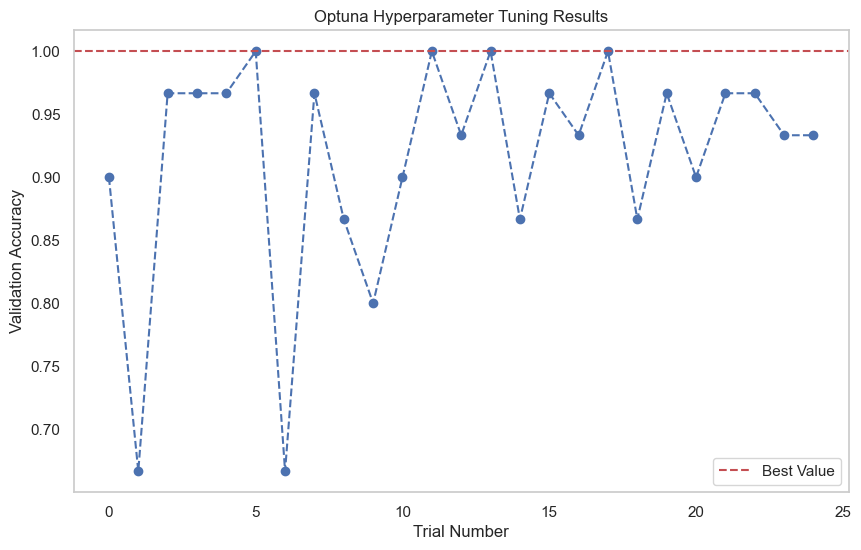

In [14]:
# plot the results
import matplotlib.pyplot as plt
import seaborn as sns

# plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title("Optuna Hyperparameter Tuning Results")
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.plot([t.number for t in study.trials], [t.value for t in study.trials], marker="o", linestyle="--")
plt.axhline(y=study.best_value, color='r', linestyle='--', label='Best Value')
plt.legend()
plt.grid()
plt.show()